# Analysis 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import seaborn as sns
from scipy.stats import pearsonr

ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "/Users/federicacardillo/Downloads/y/envs/pRFfitting/bin/python"
  * The NumPy version is: "1.24.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Users/federicacardillo/Downloads/y/envs/pRFfitting/lib/python3.9/site-packages/numpy/core/_multiarray_umath.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/libgfortran.5.dylib
  Referenced from: <D37BED4E-7F75-3467-A281-7E7E316989C9> /Users/federicacardillo/Downloads/y/envs/pRFfitting/lib/libopenblas.0.dylib
  Reason: tried: '/Users/federicacardillo/Downloads/y/envs/pRFfitting/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/federicacardillo/Downloads/y/envs/pRFfitting/lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/federicacardillo/Downloads/y/envs/pRFfitting/lib/python3.9/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/federicacardillo/Downloads/y/envs/pRFfitting/lib/python3.9/site-packages/numpy/core/../../../../libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/federicacardillo/Downloads/y/envs/pRFfitting/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/Users/federicacardillo/Downloads/y/envs/pRFfitting/bin/../lib/libgfortran.5.dylib' (duplicate LC_RPATH '@loader_path'), '/usr/local/lib/libgfortran.5.dylib' (no such file), '/usr/lib/libgfortran.5.dylib' (no such file, not in dyld cache)


In [ ]:
# Directories 
CFM = "/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/CFM"
base_output_dir = f"{CFM}/statistics/visualfield"
os.makedirs(base_output_dir, exist_ok=True)

# Parameters
ve = 0.1
rois = ['V2', 'V3'] 
atlas = ['manual']
all_subject_quadrant_stats = []

Plot the Connective Field sizes on the visual field coordinates

In [ ]:
#results = glob.glob(f"{CFM}/sub-*/ses-02/manual/RestingState/run-1/nordic/GM/*/V*-V1/best_fits_prf.csv")
results = glob.glob(f"{CFM}/sub-*/ses-02/manual/RET2/nordic/GM/*/V*-V1/best_fits_prf.csv")

subject_files = {}
for result in results:
    subj = result.split("/")[8]
    if subj not in subject_files:
        subject_files[subj] = []  # Initialize the list if key doesn't exist
    subject_files[subj].append(result)  # Now safe to append

In [ ]:
for subj, files in subject_files.items():
    subject_dir = os.path.join(base_output_dir, subj)
    datas = []

    for f in files:
        hemi = f.split("/")[-3]
        roi = os.path.basename(os.path.dirname(f)).split('-')[0]
        data = pd.read_csv(f)
        data = data[data['Best Variance Explained Finer'] > ve]
        ecc = data['Source Eccentricity'].values
        pol = data['Source Polar Angle'].values
        sigma = data['Best Sigma Finer'].values
        x = ecc * np.cos(pol) # Convert polar coordinates to Cartesian X 
        y = ecc * np.sin(pol) # Convert polar coordinates to Cartesian X
        summary_data = pd.DataFrame({
            "x": x, "y": y, "sigma": sigma,
            "ecc": ecc, "pol": pol,
            "roi": roi, "hemi": hemi
        })
        datas.append(summary_data)

    data = pd.concat(datas)
    plt.figure(figsize=(7, 7))
    norm_sigma = (data["sigma"] - data["sigma"].min()) / (data["sigma"].max() - data["sigma"].min())
    sizes = np.clip(norm_sigma * 270 + 30, 30, 300)
    sc = plt.scatter(data["x"], data["y"], s=sizes, c=norm_sigma, cmap='Greys', alpha=0.7, edgecolor='k', linewidth=0.3)
    # Plot all the points in grey scale 
    
    plt.colorbar(sc).set_label("CF Size (mm)")
    plt.title(f"Connective Fields in the Visual Field {subj}\nN = {len(data)}")
    plt.xlabel("Visual Field X (deg)")
    plt.ylabel("Visual Field Y (deg)")
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(subject_dir, "cf_invisualfield.jpg"))
    plt.close()

    # Plot all the points per hemisphere
    for hemi in ['lh', 'rh']:
        hemi_data = data[data["hemi"] == hemi]
        norm_sigma = (hemi_data["sigma"] - data["sigma"].min()) / (data["sigma"].max() - data["sigma"].min())
        sizes = np.clip(norm_sigma * 270 + 30, 30, 300)

        plt.figure(figsize=(7, 7))
        sc = plt.scatter(hemi_data["x"], hemi_data["y"], s=sizes, c=norm_sigma,
                        cmap='Greys', alpha=0.7, edgecolor='k', linewidth=0.3)
        plt.colorbar(sc).set_label("CF Size (mm)")
        plt.title(f"Connective Fields in {hemi.upper()} {subj}\nN = {len(hemi_data)}")
        plt.xlabel("Visual Field X (deg)")
        plt.ylabel("Visual Field Y (deg)")
        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(subject_dir, f"cf_hemi_{hemi}.jpg"))
        plt.close()

    # Plot all the points per visual area
    for roi in rois:
        roi_data = data[data["roi"] == roi]
        norm_sigma = (roi_data["sigma"] - data["sigma"].min()) / (data["sigma"].max() - data["sigma"].min())
        sizes = np.clip(norm_sigma * 270 + 30, 30, 300)

        plt.figure(figsize=(7, 7))
        sc = plt.scatter(roi_data["x"], roi_data["y"], s=sizes, c=norm_sigma,
                        cmap='Greys', alpha=0.7, edgecolor='k', linewidth=0.3)
        plt.colorbar(sc).set_label("CF Size (mm)")
        plt.title(f"{subj} - CFs ({roi})\nN = {len(roi_data)}")
        plt.xlabel("Visual Field X (deg)")
        plt.ylabel("Visual Field Y (deg)")
        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(subject_dir, f"cf_{roi}.jpg"))
        plt.close()

Associate the connective fields with the respective quadrant HFA value

Columns in ophth_df: ['Subject', 'DX_UL', 'DX_UR', 'DX_DL', 'DX_DR', 'RX_UL', 'RX_UR', 'RX_DL', 'RX_DR', 'DX_RX_UL', 'DX_RX_UR', 'DX_RX_DL', 'DX_RX_DR', 'Unnamed: 13']

--- VF vs CF Quadrant Analysis ---
   subject worst_vf_quadrant  worst_vf_value  cf_in_worst_quad  \
0   sub-02       Upper Right         -17.375          0.848996   
1   sub-04        Lower Left         -26.250          0.808941   
2   sub-05       Upper Right         -11.000          0.818399   
3   sub-07        Upper Left          -7.625          0.920182   
4   sub-08       Upper Right         -16.125          0.856591   
5   sub-09        Upper Left          -4.750          1.090270   
6   sub-10       Upper Right         -28.125          0.880319   
7   sub-11        Upper Left          -2.875          0.672223   
8   sub-12        Upper Left         -19.375          0.942581   
9   sub-14       Lower Right         -16.250          0.911214   
10  sub-15       Upper Right          -4.125          0.996714   
11  

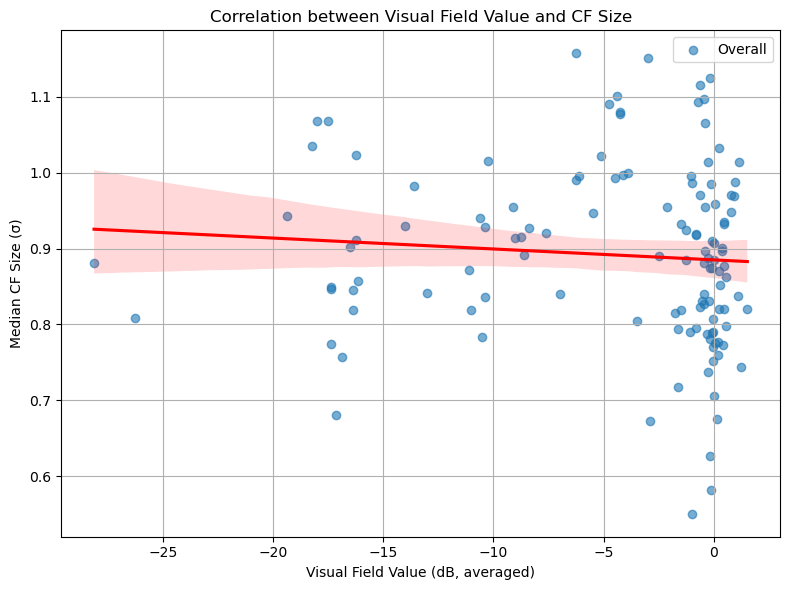

Pearson correlation: r = 0.008, p = 8.053e-01


In [ ]:
# === Load the ophthalmological Excel file ===
ophth_path = "/Users/federicacardillo/Desktop/EGRET-AAA/2025/OphthalmologicalTests/ophthtests.xlsx"
ophth_df = pd.read_excel(ophth_path)
print("Columns in ophth_df:", ophth_df.columns.tolist())


# === Define quadrant keys and mappings ===
quadrants = ['UL', 'UR', 'DL', 'DR']
quad_map = {
    'UL': 'Upper Left',
    'UR': 'Upper Right',
    'DL': 'Lower Left',
    'DR': 'Lower Right'
}

def get_eye_value(row, quad, eye):
    left_col = f'RX_{quad}'   # left eye
    right_col = f'DX_{quad}'  # right eye
    both_col = f'DX_RX_{quad}'  # average of both

    def parse(val):
        if isinstance(val, str) and val.strip().startswith('['):
            try:
                return np.mean(eval(val))
            except:
                return np.nan
        return val

    left_val = parse(row.get(left_col, np.nan))
    right_val = parse(row.get(right_col, np.nan))
    both_val = parse(row.get(both_col, np.nan))

    if eye == 'left':
        return left_val
    elif eye == 'right':
        return right_val
    elif eye == 'both':
        return both_val
    elif eye == 'best':
        return np.nanmax([left_val, right_val])
    elif eye == 'worst':
        return np.nanmin([left_val, right_val])
    else:
        return np.nan



# === Process all combinations ===
def run_analysis(subject_files, ve, roi_mode='all', eye_mode='both'):
    # 1. Parse ophthalmological data
    vf_data = []
    for idx, row in ophth_df.iterrows():
        subject = row['Subject']
        for quad in quadrants:
            avg_value = get_eye_value(row, quad, eye_mode)
            vf_data.append({
                'subject': subject,
                'cf_quadrant': quad_map[quad],
                'vf_mean': avg_value
            })

    vf_avg = pd.DataFrame(vf_data)

    # 2. Extract CF quadrant data
    cf_quadrant_data = []
    for subj, files in subject_files.items():
        datas = []
        for f in files:
            hemi = f.split("/")[-3]
            roi = os.path.basename(os.path.dirname(f)).split('-')[0]
            if roi_mode != 'all' and roi != roi_mode:
                continue

            data = pd.read_csv(f)
            data = data[data['Best Variance Explained Finer'] > ve]
            ecc = data['Source Eccentricity'].values
            pol = data['Source Polar Angle'].values
            sigma = data['Best Sigma Finer'].values
            x = ecc * np.cos(pol)
            y = ecc * np.sin(pol)

            df = pd.DataFrame({
                "subject": subj,
                "roi": roi,
                "hemi": hemi,
                "x": x,
                "y": y,
                "sigma": sigma
            })

            conditions = [
                (df['x'] < 0) & (df['y'] > 0),
                (df['x'] > 0) & (df['y'] > 0),
                (df['x'] < 0) & (df['y'] < 0),
                (df['x'] > 0) & (df['y'] < 0),
            ]
            labels = ['Upper Left', 'Upper Right', 'Lower Left', 'Lower Right']
            df['cf_quadrant'] = np.select(conditions, labels, default=np.nan)

            datas.append(df)

        subject_data = pd.concat(datas, ignore_index=True)

        for quad, quad_data in subject_data.groupby('cf_quadrant'):
            if not quad_data.empty:
                cf_quadrant_data.append({
                    'subject': subj,
                    'cf_quadrant': quad,
                    'cf_median': quad_data['sigma'].median(),
                    'roi': roi_mode if roi_mode != 'all' else 'combined'
                })

    cf_quadrant_df = pd.DataFrame(cf_quadrant_data)
    merged = pd.merge(vf_avg, cf_quadrant_df, on=['subject', 'cf_quadrant'], how='inner')

    # 3. Compare worst VF quadrant to CF
    results = []
    for subj, group in merged.groupby('subject'):
        if group.empty:
            continue
        worst_quad = group.loc[group['vf_mean'].idxmin()]
        largest_cf_quad = group.loc[group['cf_median'].idxmax()]
        if worst_quad['cf_quadrant'] == largest_cf_quad['cf_quadrant']:
            relation = 'largest'
        elif worst_quad['cf_median'] == group['cf_median'].min():
            relation = 'smallest'
        else:
            relation = 'neither'
        results.append({
            'subject': subj,
            'worst_vf_quadrant': worst_quad['cf_quadrant'],
            'worst_vf_value': worst_quad['vf_mean'],
            'cf_in_worst_quad': worst_quad['cf_median'],
            'largest_cf_quadrant': largest_cf_quad['cf_quadrant'],
            'largest_cf_value': largest_cf_quad['cf_median'],
            'relation': relation
        })

    result_df = pd.DataFrame(results)
    print("\n--- VF vs CF Quadrant Analysis ---")
    print(result_df)
    print("\n--- Summary ---")
    print(result_df['relation'].value_counts())

    # 4. Correlation plot
    plot_data = merged.dropna(subset=['vf_mean', 'cf_median'])

    plt.figure(figsize=(8, 6))
    sns.regplot(
        data=plot_data,
        x='vf_mean',
        y='cf_median',
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'},
        label='Overall'
    )

    if roi_mode == 'all':
        for roi_name, color in {'V2': 'blue', 'V3': 'green'}.items():
            subset = plot_data[plot_data['roi'] == roi_name]
            if not subset.empty:
                sns.regplot(
                    data=subset,
                    x='vf_mean',
                    y='cf_median',
                    scatter=False,
                    line_kws={'color': color},
                    label=f'{roi_name}'
                )

    plt.xlabel("Visual Field Value (dB, averaged)")
    plt.ylabel("Median CF Size (σ)")
    plt.title("Correlation between Visual Field Value and CF Size")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # r, p = pearsonr(plot_data['vf_mean'], plot_data['cf_median'])
    from scipy.stats import spearmanr
    r, p = spearmanr(x, y)
    print(f"Pearson correlation: r = {r:.3f}, p = {p:.3e}")

run_analysis(subject_files, ve=0.1, roi_mode='all', eye_mode='both')

Trend line analysis of the CF size

In [ ]:
def bootstrap_weighted_avg(x, y, r2, n_samples, confidence, task, ecc_bound, roi_name, subject_num, group_type=None, output_dir=None, atlas=atlas):
    '''Functixon to create a bootstrapped weighted average plot'''
    # Set the Seaborn plotting style to 'white' for a clean background
    sns.set_style('white')
    # Assign color based on the group type or ROI name
    colors = {'V1': 'blue', 'V2': 'orange', 'V3': 'green', 'V4': 'pink', 'LO': 'red', 'glaucoma': 'red', 'control': 'blue'}
    # Get the color for the group or ROI; default to 'gray' if group/ROI is not in the dictionary
    group_color = colors.get(group_type, colors.get(roi_name, 'gray'))
    # Scatter plot of the x and y data, with transparency set by the R2 value
    plt.scatter(x, y, alpha=r2, marker='o', s=1, color=group_color)

    # Sort the data to fit trend lines properly 
    sorted_idx = np.argsort(x)
    x, y, r2 = x[sorted_idx], y[sorted_idx], r2[sorted_idx]
    # Generate evenly spaced x values for fitting trendlines within the specified eccentricity bounds
    x_fit = np.linspace(ecc_bound[0], ecc_bound[1], len(x))
    y_fit_samples = np.zeros((n_samples, len(x_fit)))

    # Bootstrapping process: create multiple trend lines based on resampled data
    for i in range(n_samples):
        # Randomly choose indices to create a bootstrap sample
        rnd_idx = np.random.choice(len(x), size=len(x), replace=True)
        # Resample the x, y, and r2 data using the random indices
        res_x, res_y, res_r2 = x[rnd_idx], y[rnd_idx], r2[rnd_idx]
        # Fit a linear model (degree 1 polynomial) to the resampled data, weighted by r2
        model = np.polyfit(res_x, res_y, deg=1, w=res_r2)
        # Calculate the y-values for the fitted line and store in y_fit_samples
        y_fit_samples[i, :] = model[0] * x_fit + model[1]
        # y_fit_samples[i, :] = model[0] * x_fit # model[1] offset removed

    # Calculate the mean trend line and the confidence interval bounds from bootstrapped samples
    # MEDIAN TRENDLINE
    y_mean_fit = np.median(y_fit_samples, axis=0)
    # MEAN TREND LINE 
    # y_mean_fit = np.mean(y_fit_samples, axis=0)
    # y_mean_fit = model[0] * x_fit  
    lower_bounds = np.percentile(y_fit_samples, 2.5, axis=0) # 2.5th percentile for lower bound
    upper_bounds = np.percentile(y_fit_samples, 97.5, axis=0) # 97.5th percentile for upper bound
    
    # Fit the final model to the entire dataset to extract trendline parameters (slope and offset)
    final_model = np.polyfit(x, y, deg=1, w=r2)
    slope, offset = final_model

    # Plot the trend line based on the mean fit and add a label to the plot
    plt.plot(x_fit, y_mean_fit, ls='solid', linewidth=1.5, alpha=1, color=group_color, 
         label=f'{roi_name} (N = {len(r2)}): y = {np.polyfit(x, y, deg=1, w=r2)[0]:.4f}x + {np.polyfit(x, y, deg=1, w=r2)[1]:.4f}')
    # Plot the confidence interval as a shaded area around the trend line
    plt.fill_between(x_fit, lower_bounds, upper_bounds, color='gray', alpha=0.2)
    # Add title, labels, limits, and legend to the plot
    plt.title(f'{subject_num}: Trendline for {roi_name}', fontsize=18)
    plt.xlabel('Eccentricity', fontsize=16) # Label for the x-axis
    plt.ylabel('CF Size', fontsize=16) # Label for the y-axis
    plt.ylim([0, 2.5]) # Set y-axis limits to maintain consistent scale
    plt.legend(loc='upper left') # Position the legend in the upper left
    plt.grid(True) # Display a grid on the plot
    plt.tight_layout() # Adjust the padding of the plot for a clean layout

    return x_fit, y_mean_fit, lower_bounds, upper_bounds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re

# === CONFIGURATION ===
rois_to_plot = ['V2', 'V3']
ecc_bound = [0, 8]
n_bootstrap_samples = 1000
confidence = 0.95
task = "RET"
atlas = None
ve = 0.3

# === Paths ===
ophth_path = "/Users/federicacardillo/Desktop/EGRET-AAA/2025/OphthalmologicalTests/ophthtests.xlsx"
output_dir = "/Users/federicacardillo/Desktop/EGRET-AAA/2025/connectivefieldmodeling/linearmixedeffectsmodel/trendlines_cf"
output_path = os.path.join(output_dir, "trendlines_cf_summary.xlsx")
os.makedirs(output_dir, exist_ok=True)

# === Load ophthalmology file ===
ophth_df = pd.read_excel(ophth_path)

# === Helper functions ===
def extract_subject_number(subj):
    return int(re.search(r'\d+', subj).group())

def get_hfa_stats(subject):
    row = ophth_df[ophth_df["Subject"] == subject]
    if row.empty:
        return (np.nan, np.nan, np.nan)
    hfa_values = []
    for q in ['UL', 'UR', 'DL', 'DR']:
        colname = f"DX_RX_{q}"
        val = row.iloc[0][colname]
        if isinstance(val, str) and val.strip().startswith('['):
            try:
                val_list = eval(val)
                hfa_values.extend(val_list)
            except:
                continue
        else:
            hfa_values.append(val)
    if not hfa_values:
        return (np.nan, np.nan, np.nan)
    return (np.mean(hfa_values), np.max(hfa_values), np.min(hfa_values))

# === Begin loop across all subjects ===
trendline_records = []

for subject_id, files in subject_files.items():
    datas = []

    for f in files:
        hemi = f.split("/")[-3]
        roi = os.path.basename(os.path.dirname(f)).split('-')[0]
        if roi not in rois_to_plot:
            continue

        data = pd.read_csv(f)
        data = data[data['Best Variance Explained Finer'] > ve]

        # Apply sigma filtering directly during assignment
        sigma_raw = data['Best Sigma Finer'].values
        mask = (sigma_raw >= 0.1) & (sigma_raw <= 6.5)

        ecc = data['Source Eccentricity'].values[mask]
        sigma = sigma_raw[mask]
        r2 = data['Best Variance Explained Finer'].values[mask]

        df = pd.DataFrame({
            "subject": subject_id,
            "roi": roi,
            "eccentricity": ecc,
            "sigma": sigma,
            "r2": r2
        })
        datas.append(df)

    if not datas:
        continue

    data_all = pd.concat(datas)

    # Plot per subject (optional: comment this out if not needed)
    plt.figure(figsize=(10, 6))
    for roi in rois_to_plot:
        roi_data = data_all[data_all["roi"] == roi]
        if roi_data.empty:
            continue

        x = roi_data['eccentricity'].values
        y = roi_data['sigma'].values
        r2 = roi_data['r2'].values

        sorted_idx = np.argsort(x)
        x = x[sorted_idx]
        y = y[sorted_idx]
        r2 = r2[sorted_idx]

        x_fit = np.linspace(ecc_bound[0], ecc_bound[1], len(x))
        y_fit_samples = np.zeros((n_bootstrap_samples, len(x_fit)))

        for i in range(n_bootstrap_samples):
            rnd_idx = np.random.choice(len(x), size=len(x), replace=True)
            res_x, res_y, res_r2 = x[rnd_idx], y[rnd_idx], r2[rnd_idx]
            model = np.polyfit(res_x, res_y, deg=1, w=res_r2)
            y_fit_samples[i, :] = model[0] * x_fit + model[1]

        y_median_fit = np.median(y_fit_samples, axis=0)
        lower_bounds = np.percentile(y_fit_samples, 2.5, axis=0)
        upper_bounds = np.percentile(y_fit_samples, 97.5, axis=0)

        final_model = np.polyfit(x, y, deg=1, w=r2)
        slope, offset = final_model
        conf_low = lower_bounds[0]
        conf_high = upper_bounds[0]

        # Plot (optional)
        color = {'V2': 'orange', 'V3': 'green'}.get(roi, 'gray')
        plt.plot(x_fit, y_median_fit, label=f"{roi}: y={slope:.4f}x+{offset:.4f}", color=color)
        plt.fill_between(x_fit, lower_bounds, upper_bounds, alpha=0.2, color=color)
        plt.scatter(x, y, s=2, alpha=r2, color=color)

        # Record trendline values
        subj_num = extract_subject_number(subject_id)
        group = "Primary Open-Angle Glaucoma" if subj_num <= 20 else "Healthy Controls"
        hfa_avg, hfa_best, hfa_worst = get_hfa_stats(subject_id)

        trendline_records.append({
            "Subject Number": subject_id,
            "Visual Area": roi,
            "Offset": offset,
            "Slope": slope,
            "Confidence Interval Lower Bound": conf_low,
            "Confidence Interval Upper Bound": conf_high,
            "Group": group,
            "HFA Average": hfa_avg,
            "OCT Average": "",
            "HFA Best": hfa_best,
            "OCT Best": "",
            "HFA Worst": hfa_worst,
            "OCT Worst": ""
        })

    # Optional: save figure
    plt.title(f"{subject_id} - CF Size vs Eccentricity (V2 & V3)")
    plt.xlabel("Eccentricity (deg)")
    plt.ylabel("CF Size (σ)")
    plt.ylim([0, 2.5])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{subject_id}_cf_trendlines.png"))
    plt.close()

# === Export to Excel ===
df_trendlines = pd.DataFrame(trendline_records)
df_trendlines.to_excel(output_path, index=False)